En esta sección trataremos de ver como se comportan los 4 mejores modelos entrenados en el notebook `modelosML.ipynb`. Aquí los entrenaremos con Cross Validation para evitar el sobreajuste. Mostraremos matrices de confusión y curvas para ver que modelo es el mejor.

Para empezar leeremos los datos de train y validacion, después los uniremos, los mezclaremos haciendo un sort para después aplicar un Cross Validarion con los diferentes modelos. Todos estos modelos serán cargados de la biblioteca `sklearn`

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Cambiar el directorio de trabajo
ruta_nueva = 'C:/Users/ruben.morillas/Desktop/aaa/'  # Reemplaza 'TuUsuario' con tu nombre de usuario de Windows
os.chdir(ruta_nueva)

# Mostrar el directorio actual para confirmar el cambio
directorio_actual = os.getcwd()
print("Directorio actual:", directorio_actual)

Directorio actual: C:\Users\ruben.morillas\Desktop\aaa


In [3]:
# Leemos los datos de train
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)
df_train = pd.read_csv(path_train, index_col=None)

In [4]:
# Leemos los datos de validacion
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual,subdirectorio, file_valid)
df_valid = pd.read_csv(path_valid, index_col=None)

In [5]:
# Unimos los dos pandas para juntar los datos de train con los de validacion.
print('Dimensiones df_train:', df_train.shape)
print('Dimensiones df_valid:', df_valid.shape)
df_combinado = pd.concat([df_train, df_valid])
print('Dimensiones combinado:', df_combinado.shape)

Dimensiones df_train: (11612557, 8)
Dimensiones df_valid: (3267904, 8)
Dimensiones combinado: (14880461, 8)


In [6]:
def filtrado_datos(df, N):
    kaones = []
    labels = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]
            grupo_ordenado = grupo_filtrado.head(N)

            # Inicializar arrays para el padding
            hitX_padded = np.zeros(N)
            hitY_padded = np.zeros(N)
            hitZ_padded = np.zeros(N)
            hitInteg_padded = np.zeros(N)

            # Separar y aplicar padding a los valores de hitX, hitY, hitZ, hitInteg
            hitX_padded[:len(grupo_ordenado['hitX'])] = grupo_ordenado['hitX']
            hitY_padded[:len(grupo_ordenado['hitY'])] = grupo_ordenado['hitY']
            hitZ_padded[:len(grupo_ordenado['hitZ'])] = grupo_ordenado['hitZ']
            hitInteg_padded[:len(grupo_ordenado['hitInteg'])] = grupo_ordenado['hitInteg']

            # Concatenar los valores ya con el padding aplicado
            hit_values_reorganized = np.concatenate([hitX_padded, hitY_padded, hitZ_padded, hitInteg_padded])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return np.array(kaones), np.array(labels)

Ahora cargamos los modelos que mejor han funcionado en el notebook que hemos mencionado anteriormente, los modelos son los siguientes:
*   **LGBM**: 720 hits por evento
*   **Random Forest**: 400 hits por evento
*   **GBC**: 760 hits por evento
*   **SVM**: 800 hits por evento

In [7]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC # SVM
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier


In [8]:
X, y = filtrado_datos(df_combinado, N=800)
GBC = GradientBoostingClassifier(loss='log_loss', n_estimators=100, criterion='friedman_mse', max_features='sqrt', random_state=42, learning_rate=0.1)
scoresGBC = cross_val_score(GBC, X, y, cv=5, scoring='accuracy')
print('Valores de accuracy de GBC:', scoresGBC)

Valores de accuracy de GBC: [0.9272036  0.92057457 0.9257851  0.92719335 0.9246585 ]


In [9]:
X, y =filtrado_datos(df_combinado, N=400)
RF_model = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, max_features='sqrt', random_state=42)
scoresRF = cross_val_score(RF_model, X, y, cv=5, scoring='accuracy')
print('Valores de accuracy de RF:', scoresRF)

Valores de accuracy de RF: [0.93199099 0.93169976 0.93310801 0.93465709 0.93099563]


In [10]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

X, y = filtrado_datos(df_combinado, N=720)

# Instantiate the LGBMClassifier
LGBM_model = LGBMClassifier(boosting_type='gbdt', max_depth=6, learning_rate=0.3, subsample=1, colsample_bytree=1, random_state=42)

# Use the instance of LGBMClassifier in cross_val_score
scoresLGBM = cross_val_score(LGBM_model, X, y , cv=5, scoring='accuracy')

print('Valores de accuracy de LGBM:', scoresLGBM)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 14362, number of negative: 14042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.984551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734400
[LightGBM] [Info] Number of data points in the train set: 28404, number of used features: 2880
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505633 -> initscore=0.022533
[LightGBM] [Info] Start training from score 0.022533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [11]:
from xgboost import XGBClassifier
params = {
    'booster': 'gbtree',
    'max_depth': 6,
    'gamma': 0,
    'learning_rate': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

X, y =filtrado_datos(df_combinado, N=760)


XGB_model = XGBClassifier(**params)


print('Empieza')
scoresXGB = cross_val_score(XGB_model, X, y, cv=5, scoring='accuracy')


print('Valores de accuracy de XGBoost:', scoresXGB)

Empieza
Valores de accuracy de XGBoost: [0.95114052 0.94817631 0.95085199 0.95282355 0.94803549]


In [14]:
import matplotlib.pyplot as plt


def printMetricasScores(scoresLGBM, scoresRF, scoresXBC, scoresSVM, metrica='accuracy'):
    plt.figure(figsize=(10, 6))

    
    plt.plot(scoresLGBM, label='LGBM', marker='_')
    plt.plot(scoresRF, label='Random Forest', marker='_')
    plt.plot(scoresXBC, label='XGB', marker='_')
    plt.plot(scoresSVM, label='SVM', marker='_')

    plt.title('Metricas de ' + metrica)  
    plt.xlabel('Entrenamiento en CV')
    plt.ylabel('Valores de ' + metrica)  
    plt.grid(True)
    plt.legend()  
    plt.show()


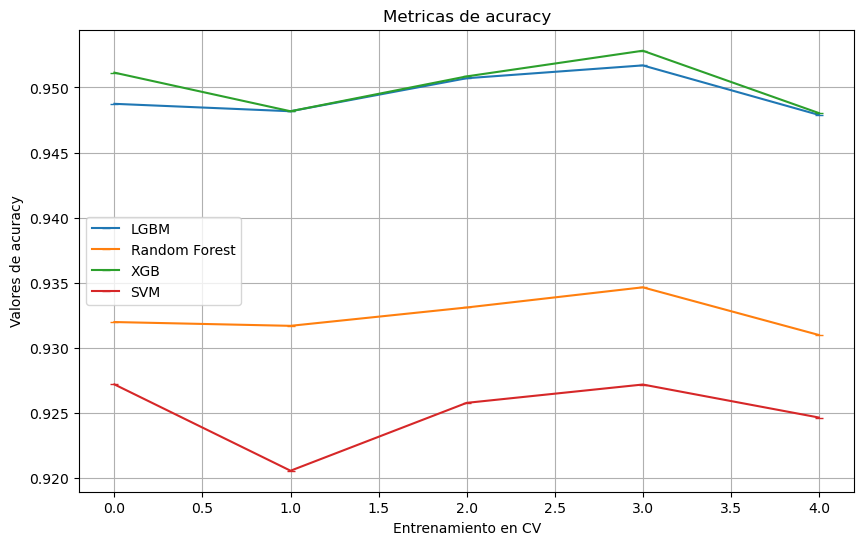

In [15]:
printMetricasScores(scoresLGBM, scoresRF, scoresXGB, scoresGBC, metrica='acuracy')